## Visualization for splice relevant variants

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# all variants, original naga table with VEP, FLOSSIES, HBOC annotations
all_vars = pd.read_pickle('00_dataframes/naga_vep_floss_hboc')
all_vars['#CHROM'] = pd.Categorical(all_vars['#CHROM'],
                                    categories=['1','2','3','4','5','6','7','8','9','10','11','12', '13', '14', 
                                                '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y'],
                                    ordered=True)
all_vars = all_vars.sort_values(by=['#CHROM', 'POS', 'REF', 'ALT'], ignore_index=True)

In [3]:
# for grouped variants by CHROM, POS, REF, ALT
vars_only = all_vars[['#CHROM', 'POS', 'REF', 'ALT', 'PosExon_type', 'PosExonRefSeqAccession']
                    ].drop_duplicates().reset_index(drop=True)

In [4]:
# function to search for specific name in column
def search_col(inp):
    return [i for i in all_vars.columns if inp in i.lower()]

columns_df_prior = ['#CHROM', 'POS', 'REF', 'ALT', 'MaxEntScan_alt', 'MaxEntScan_diff', 'MaxEntScan_ref', 
                    'CADD_PHRED', 'SpliceAI_pred_DP_AG', 'SpliceAI_pred_DP_AL', 'SpliceAI_pred_DP_DG', 
                    'SpliceAI_pred_DP_DL', 'SpliceAI_pred_DS_AG', 'SpliceAI_pred_DS_AL', 'SpliceAI_pred_DS_DG', 
                    'SpliceAI_pred_DS_DL', 'SpliceAI_pred_SYMBOL', 'ada_score', 'rf_score',
                    'PosExonRefSeqAccession', 'PosExon_type', 'ClinVar_Pathogenicity', 'ClinVar_Traits', 'PID']
cols_cpra = ['#CHROM', 'POS', 'REF', 'ALT']

### localization variant distribution

In [324]:
# two different values for outside and inside donor site
all_vars['PosExon_type'] = all_vars['PosExon_type'].replace(to_replace='outsideDonor', value='outsideDonorSite')
all_vars['PosExon_type'] = all_vars['PosExon_type'].replace(to_replace='insideDonor', value='insideDonorSite')

In [134]:
# value counts for each category and each position to e/i boundary
localiz = [(cat, pd.DataFrame(all_vars['PosExonRefSeqAccession'][all_vars['PosExon_type']==cat].value_counts()
                             ).sort_index()) for cat in all_vars['PosExon_type'].unique()]
localiz_only = [(cat, pd.DataFrame(vars_only['PosExonRefSeqAccession'][vars_only['PosExon_type']==cat
                                                                      ].value_counts()).sort_index()) 
                for cat in vars_only['PosExon_type'].unique()]

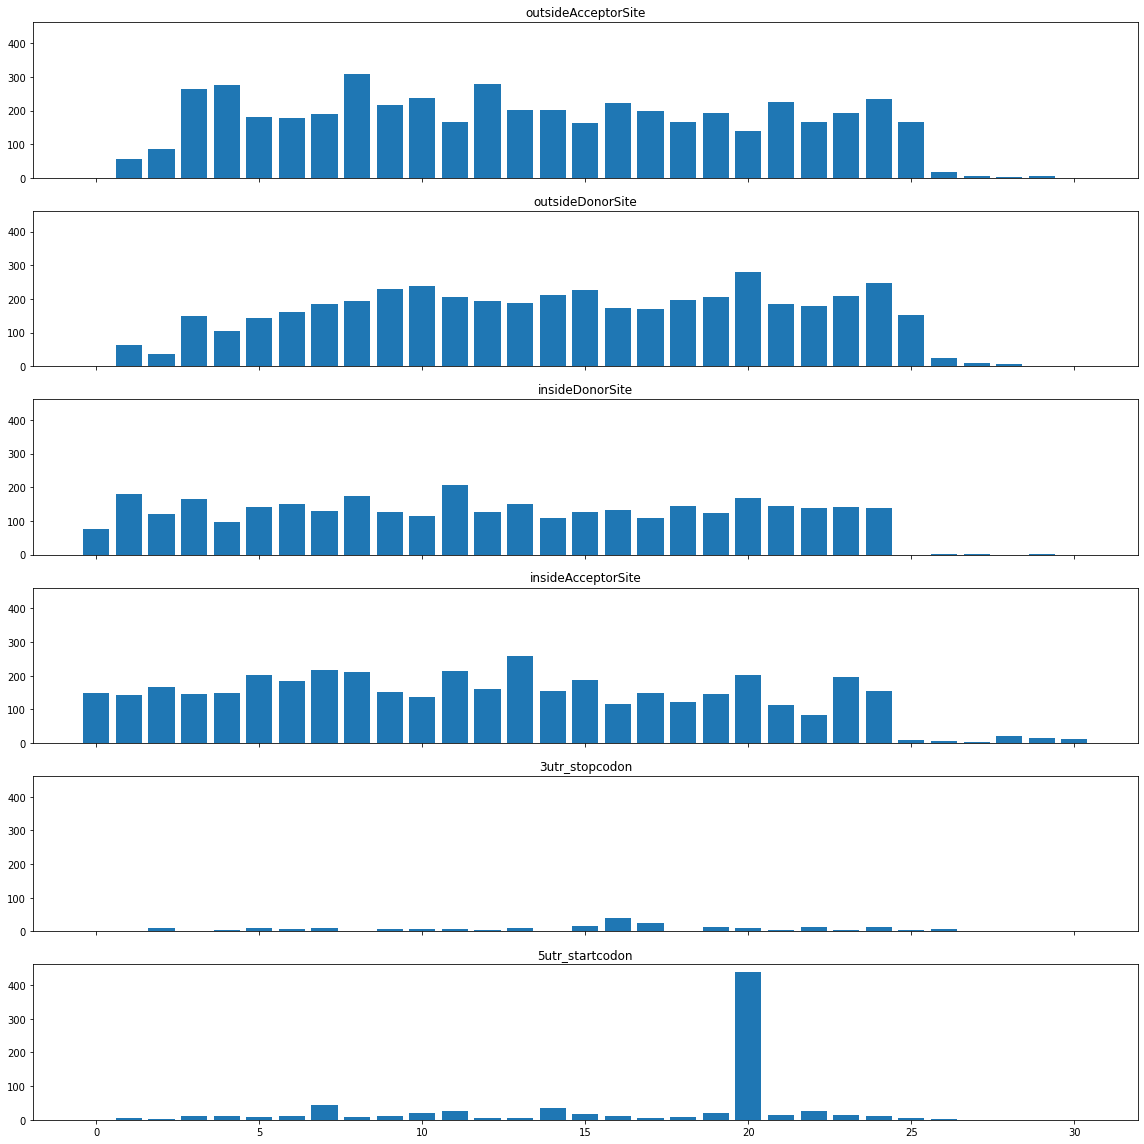

In [93]:
# for all variants with incidence in patients
fig,axs = plt.subplots(len(localiz), sharey=True, sharex = True, figsize=(16,16))
for i, (cat, df) in zip(axs, localiz):
    i.bar(x=list(df.index),height=list(df['PosExonRefSeqAccession']))
    i.set_title(cat)
plt.tight_layout()

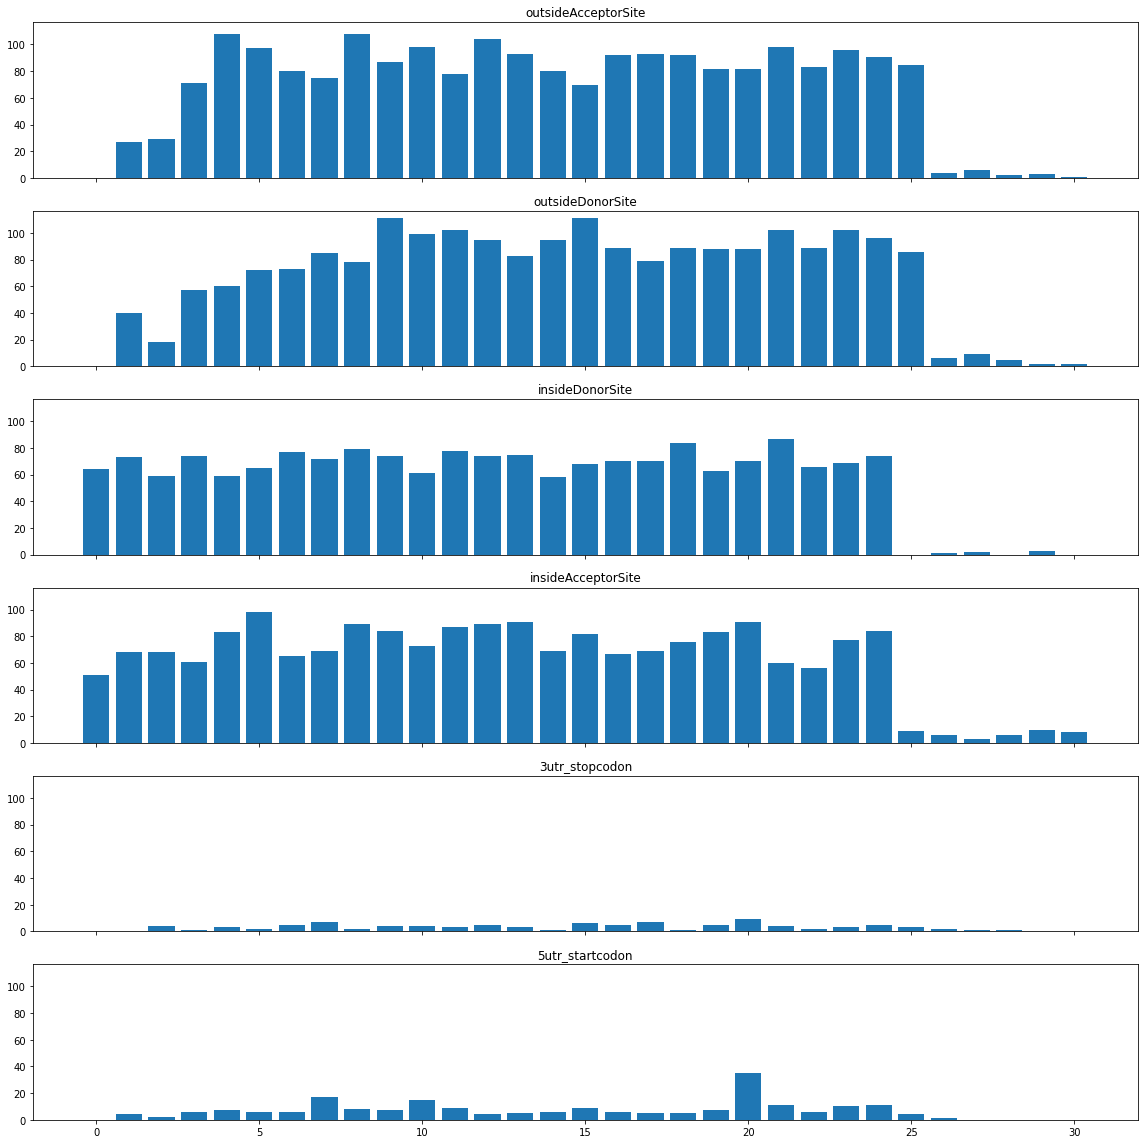

In [103]:
# for variants without incidence in patients
fig,axs = plt.subplots(len(localiz), sharey=True, sharex = True, figsize=(16,16))
for i, (cat, df) in zip(axs, localiz_only):
    i.bar(x=list(df.index),height=list(df['PosExonRefSeqAccession']))
    i.set_title(cat)
plt.tight_layout()

#### with ClinVar groups

In [325]:
# clean clinvar labels
clinv_df = all_vars.copy()
clinv_df
clinv_df['ClinVar_Pathogenicity'] = clinv_df['ClinVar_Pathogenicity'].replace(
    [np.nan, 'uncertain_significance', 'Uncertain significance', 'not_provided'], 'Uncertain Significance')

In [297]:
# for each group for each position clinvar characterizations
clinvars = [(typ, pos, [(ind, num) for ind, num in zip(list(clinv_df['ClinVar_Pathogenicity'][
    (clinv_df['PosExonRefSeqAccession']==pos)&(clinv_df['PosExon_type']==typ)].value_counts().index), 
    list(clinv_df['ClinVar_Pathogenicity'][(clinv_df['PosExonRefSeqAccession']==pos)&
                                           (clinv_df['PosExon_type']==typ)].value_counts().values))])
            for typ in clinv_df['PosExon_type'].unique() 
            for pos in clinv_df['PosExonRefSeqAccession'][clinv_df['PosExon_type']==typ].unique()]

In [299]:
clinvars_df = pd.DataFrame(clinvars, columns=['PosExon_type', 'PosExonRefSeqAccession', 'ClinVar_Pathogenicity']
                          ).sort_values(by=['PosExon_type', 'PosExonRefSeqAccession'], ignore_index=True)

In [313]:
clinvars_df[[1,2,3,4,5]] = pd.DataFrame(clinvars_df.ClinVar_Pathogenicity.tolist(), index=clinvars_df.index)

In [318]:
clinvars_df#.iloc[0][1]

,PosExon_type,PosExonRefSeqAccession,ClinVar_Pathogenicity,1,2,3,4,5
0,3utr_stopcodon,2,"[(Benign, 7), (Uncertain Significance, 3)]","(Benign, 7)","(Uncertain Significance, 3)",None,None,None
1,3utr_stopcodon,3,"[(Uncertain Significance, 1)]","(Uncertain Significance, 1)",None,None,None,None
2,3utr_stopcodon,4,"[(Uncertain Significance, 3)]","(Uncertain Significance, 3)",None,None,None,None
3,3utr_stopcodon,5,"[(Likely Benign, 8), (Uncertain Significance, 1)]","(Likely Benign, 8)","(Uncertain Significance, 1)",None,None,None
4,3utr_stopcodon,6,"[(Uncertain Significance, 5), (Benign, 3)]","(Uncertain Significance, 5)","(Benign, 3)",None,None,None
...,...,...,...,...,...,...,...,...
222,outsideDonorSite,24,"[(Uncertain Significance, 121), (Likely Benign...","(Uncertain Significance, 121)","(Likely Benign, 3)",None,None,None
223,outsideDonorSite,25,"[(Uncertain Significance, 90), (Likely Benign,...","(Uncertain Significance, 90)","(Likely Benign, 9)","(Benign, 3)",None,None
224,outsideDonorSite,27,"[(Uncertain Significance, 1)]","(Uncertain Significance, 1)",None,None,None,None
225,outsideDonorSite,28,"[(Uncertain Significance, 1)]","(Uncertain Significance, 1)",None,None,None,None


In [284]:
for i in clinv_df['ClinVar_Pathogenicity'].unique():
    clinvars_df[i] = np.nan

In [305]:
clinvars_df.iloc[0]['ClinVar_Pathogenicity'][1][1]

3

In [286]:
clinvars_df.iloc[0]['ClinVar_Pathogenicity'][clinvars_df.iloc[0]['ClinVar_Pathogenicity']['index']=='Benign'].iloc[0]['ClinVar_Pathogenicity']

7

In [279]:
clinv_cols = {'Benign':'green', 'Likely Benign':'yellowgreen', 'Uncertain Significance':'gray', 
              'Likely Pathogenic':'orange', 'Pathogenic':'red'}
new_df = clinvars_df.copy()
for i in range(len(new_df[:5])):
    for clinv in list(new_df.iloc[i]['ClinVar_Pathogenicity']['index']):
        df = new_df.iloc[i]['ClinVar_Pathogenicity']
        new_df.iloc[i][clinv] = df[df['index']==clinv].iloc[0]['ClinVar_Pathogenicity']

<ipython-input-279-66930391dae7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.iloc[i][clinv] = df[df['index']==clinv].iloc[0]['ClinVar_Pathogenicity']


In [ ]:
# for each group for each position clinvar characterizations
clinvars2 = [(typ, pos, [(ind, num) for ind, num in zip(list(clinv_df['ClinVar_Pathogenicity'][
    (clinv_df['PosExonRefSeqAccession']==pos)&(clinv_df['PosExon_type']==typ)].value_counts().index), 
    list(clinv_df['ClinVar_Pathogenicity'][(clinv_df['PosExonRefSeqAccession']==pos)&
                                           (clinv_df['PosExon_type']==typ)].value_counts().values))])
            for typ in clinv_df['PosExon_type'].unique() 
            for pos in clinv_df['PosExonRefSeqAccession'][clinv_df['PosExon_type']==typ].unique()]

In [327]:
clinv_df['ClinVar_Pathogenicity'].value_counts()

Uncertain Significance    12520
Benign                     3464
Likely Benign              2011
Pathogenic                  152
Likely Pathogenic            21
Name: ClinVar_Pathogenicity, dtype: int64

### distribution on chromosomes

In [151]:
chroms = pd.DataFrame(all_vars['#CHROM'].value_counts()).sort_index().drop(index='Y')
chroms_only = pd.DataFrame(vars_only['#CHROM'].value_counts()).sort_index().drop(index='Y')

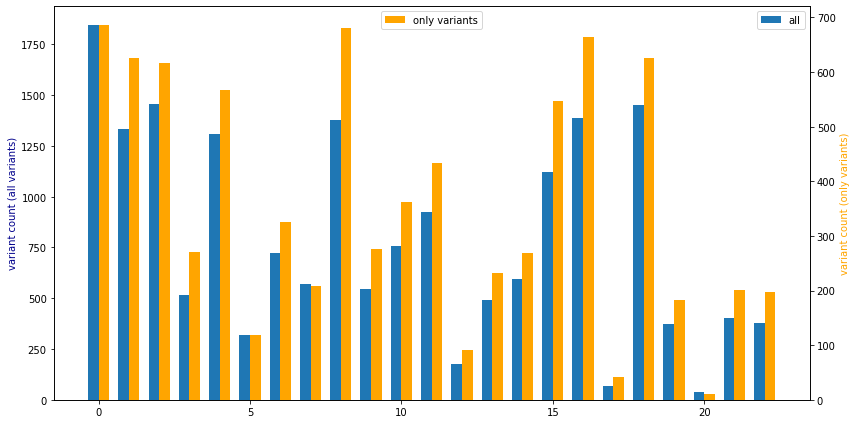

In [179]:
x = np.arange(len(chroms))
width=0.35
fig,ax1 = plt.subplots(figsize=(12,6))
ax1.bar(x-width/2, chroms['#CHROM'], width, label='all')
ax1.legend()
ax1.set_ylabel('variant count (all variants)', color='darkblue')

ax2 = ax1.twinx()
ax2.bar(x+width/2, chroms_only['#CHROM'], width, label='only variants', color='orange')
ax2.legend(loc='upper center')
ax2.set_xlabel('chromosome')
ax2.set_ylabel('variant count (only variants)', color='orange')
plt.tight_layout();